In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras_nlp.models import RobertaPreprocessor, RobertaBackbone, RobertaClassifier

print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("TensorFlow version: ", tf.__version__)

Numpy version:  1.26.4
Pandas version:  2.2.3
TensorFlow version:  2.18.0


/Users/zoe/Documents/Program/Github/NLP-with-Disaster-Tweets/mlvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
X = train_df["text"]
y = train_df["target"]

X_test = test_df["text"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# define hyper parameters
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = X.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
# Load a RoBERTa model.
preset = "roberta_base_en"

# Use a shorter sequence length.
preprocessor = RobertaPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="roberta_preprocessor_for_tweets"
)

# Pretrained classifier.
classifier = RobertaClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=1,
    activation='sigmoid'
)
classifier.summary()

Preprocessor: "roberta_preprocessor_for_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)                          │                       Vocab size: 50,265 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "roberta_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,644,097 (475.48 MB)

 Trainable params: 124,644,097 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Fit model
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

# Save model
classifier.save('model/roBERTa_classifier.keras')

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3249s 17s/step - accuracy: 0.7068 - loss: 0.5554 - val_accuracy: 0.8411 - val_loss: 0.3802
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 3785s 20s/step - accuracy: 0.8372 - loss: 0.3778 - val_accuracy: 0.8450 - val_loss: 0.3807


In [ ]:
[x[0] for x in y_val_pred]
# np.argmax(y_val_pred, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

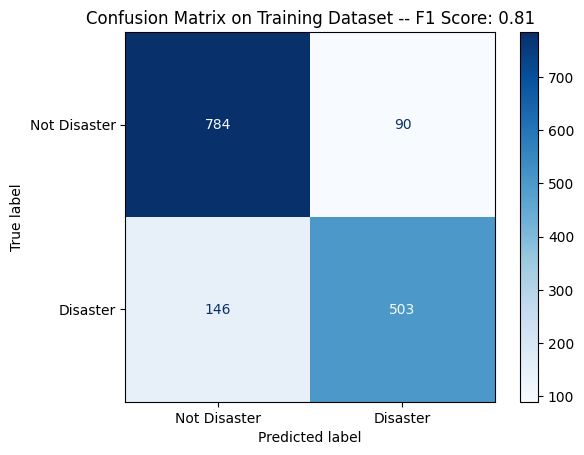

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        (y_pred >= 0.5).astype(int),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, (y_pred >= 0.5).astype(int)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

y_val_pred = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_val_pred, "Training")

In [8]:
loss, accuracy = classifier.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8399 - loss: 0.3838
Validation Accuracy: 0.8450


In [18]:
y_pred_prob = classifier.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
y_pred = [x[0] for x in y_pred]

# Create submission file
submission = pd.DataFrame({
    "id": test_df["id"],  # Ensure the test set has an "id" column
    "target": y_pred
})

# Save to CSV
current_time = datetime.now().strftime('%Y%m%d_%H%M')
submission.to_csv("Prediction/submission_" + current_time + ".csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 438s 4s/step
